Phase 1: Setup and Data Loading

In [ ]:
# cell_type: "code"

# 1. Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from google.colab import files
import numpy as np
import io
# Added imports
import os
import cv2

# 2. Define constants
IMAGE_SIZE = (224, 224) # ResNet50 expects 224x224 input
NUM_CLASSES = 10
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# *** NEW CONSTANT FOR REVISED DATA SIZE ***
IMAGES_PER_CLASS = 500

# 3. Load Fashion MNIST data
(train_images_raw, train_labels), (test_images_raw, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# 4. Create directories and save significantly more images
base_dir = 'fashion_data'
os.makedirs(base_dir, exist_ok=True)
for i, name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(base_dir, 'train', str(i))
    os.makedirs(class_dir, exist_ok=True)
    # *** REVISION: Save 500 images per class (instead of 50) ***
    for j in range(IMAGES_PER_CLASS):
        img = train_images_raw[train_labels == i][j]
        # Convert grayscale (28x28) to a 3-channel (224x224) for ResNet
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
        cv2.imwrite(os.path.join(class_dir, f'{j}.jpg'), img_resized)


# 5. Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 5000 images belonging to 10 classes.


Phase 2: Build and Train the ResNet Model

In [ ]:
# cell_type: "code"

# 6. Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 7. Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# 8. Add new classification layers (the 'top' of the model)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 9. Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# 10. Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 11. Train the model
# *** REVISION: Increased epochs from 2 to 10 for better convergence ***
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs
)

print("\nModel training complete.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 78s 412ms/step - accuracy: 0.7133 - loss: 0.9284
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8750 - loss: 0.5484  
Epoch 3/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 60s 384ms/step - accuracy: 0.8504 - loss: 0.4229
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.6875 - loss: 0.7725  
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.8634 - loss: 0.3666
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 80us/step - accuracy: 0.9062 - loss: 0.3756  
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - accuracy: 0.8829 - loss: 0.3281
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.7812 - loss: 0.5252  
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.9011 - loss: 0.2736
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.8750 - loss: 0.3864  

Model training complete.


Phase 3: Model Saving

In [ ]:
# cell_type: "code"

# 12. Save the trained model
model_save_path = 'fashion_resnet_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to fashion_resnet_model.h5


Phase 4: Interactive Prediction with File Upload

Saving 1.jpg to 1 (1).jpg
Saving 2.jpg to 2 (1).jpg
Saving 3.jpg to 3 (1).jpg
Saving 4.jpg to 4 (1).jpg

--- Processing Uploaded File: 1 (1).jpg ---



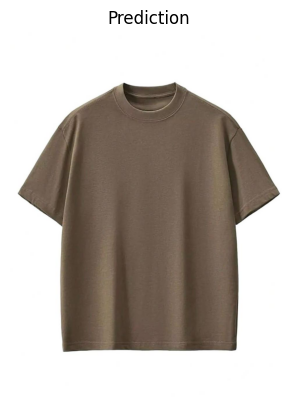

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ MODEL PREDICTION:
   The uploaded item is a: **Shirt**
   Confidence: 73.79%
--- Insight ---
⚠️ **Low Confidence:** The model's top prediction is below the 80.00% threshold.
It's possible the image is ambiguous, blurry, or contains **multiple fashion items**.
For best results, try a clear image with a single, centered item.

--- Processing Uploaded File: 2 (1).jpg ---



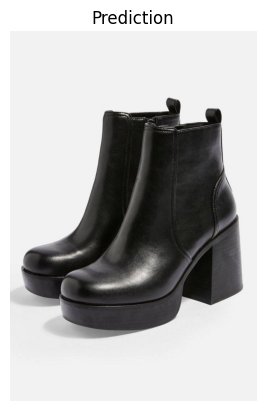

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ MODEL PREDICTION:
   The uploaded item is a: **Ankle boot**
   Confidence: 99.97%

--- Processing Uploaded File: 3 (1).jpg ---



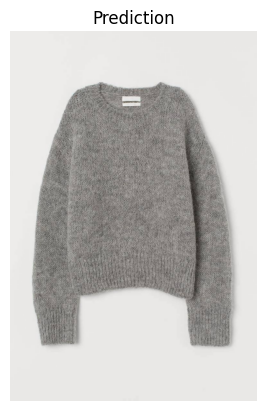

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ MODEL PREDICTION:
   The uploaded item is a: **Pullover**
   Confidence: 76.68%
--- Insight ---
⚠️ **Low Confidence:** The model's top prediction is below the 80.00% threshold.
It's possible the image is ambiguous, blurry, or contains **multiple fashion items**.
For best results, try a clear image with a single, centered item.

--- Processing Uploaded File: 4 (1).jpg ---



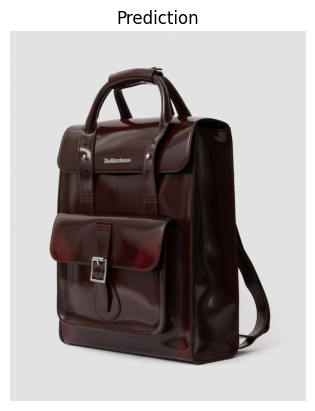

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ MODEL PREDICTION:
   The uploaded item is a: **Bag**
   Confidence: 97.02%


In [ ]:
# cell_type: "code"

# 1. Imports for Image Display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from google.colab import files
import numpy as np
import io

# Assume model, CLASS_NAMES, and IMAGE_SIZE are available

# --- Prediction Function ---
def predict_uploaded_image_with_display(model, class_names, img_size):
    """
    Prompts the user to upload an image, displays it, and prints the model's prediction,
    including an insight on low-confidence/multi-item images.
    """

    # 2. Prompt for File Upload
    uploaded = files.upload() # This opens the 'Choose File' dialog box

    # 3. Process the uploaded file
    for fn, data in uploaded.items():
        print(f'\n--- Processing Uploaded File: {fn} ---\n')

        # Read the image file bytes into a buffer
        img_buffer = io.BytesIO(data)

        # A. Display the uploaded image
        try:
            display_img = Image.open(img_buffer)
            plt.imshow(display_img)
            plt.title("Prediction")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")
            return

        # Reset the buffer's position
        img_buffer.seek(0)

        # B. Preprocess the image for ResNet prediction
        img = tf.keras.preprocessing.image.load_img(img_buffer, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        processed_img = tf.keras.applications.resnet50.preprocess_input(img_array)

        # C. Make the prediction
        predictions = model.predict(processed_img)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index] * 100

        # D. Display the Prediction Result with Confidence Check
        predicted_class_name = class_names[predicted_class_index]

        print("===============================================")
        print("✅ MODEL PREDICTION:")
        print(f"   The uploaded item is a: **{predicted_class_name}**")
        print(f"   Confidence: {confidence:.2f}%")

        # *** REVISION: Added low confidence check/multi-item warning ***
        CONFIDENCE_THRESHOLD = 80.0
        if confidence < CONFIDENCE_THRESHOLD:
            print("--- Insight ---")
            print("⚠️ **Low Confidence:** The model's top prediction is below the 80.00% threshold.")
            print("It's possible the image is ambiguous, blurry, or contains **multiple fashion items**.")
            print("For best results, try a clear image with a single, centered item.")

        print("===============================================")

# 4. Execute the interactive prediction
predict_uploaded_image_with_display(model, CLASS_NAMES, IMAGE_SIZE)